<a href="https://colab.research.google.com/github/pullelys/iml-project/blob/main/task_4/model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd
import numpy as np
from numpy import asarray
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Concatenate, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from matplotlib import image
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib as mpl

Tensorflow version 2.3.0


In [ ]:
############  ORIGINAL CODE CHANGED FOR REPRODUCABILITY  ############
############  GET DATA FROM GCS INSTEAD OF GOOGLE DRIVE  ############

# copy necessary files from Google Cloud Storage (GCS) to local disk
bucket_name = 'colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002'
files = ['food.zip', 'train_triplets.txt', 'test_triplets.txt']
for file in files:
  !gsutil cp gs://{bucket_name}/{file} .

# unzip images
!unzip -q food.zip
!rm food.zip

Copying gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/food.zip...
/ [1 files][372.4 MiB/372.4 MiB]                                                
Operation completed over 1 objects/372.4 MiB.                                    
Copying gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/train_triplets.txt...
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Operation completed over 1 objects/1.0 MiB.                                      
Copying gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_triplets.txt...
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Operation completed over 1 objects/1.0 MiB.                                      


In [ ]:
############  COMMENTED FOR (FAST) REPRODUCABILITY  ############
############  GRANT ACCESS TO GOOGLE DRIVE          ############

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
############  COMMENTED FOR (FAST) REPRODUCABILITY  ############
############  GET DATA FROM GOOGLE DRIVE            ############

# # copy necessary files from google drive to local disk
# zip_path = '/content/drive/My Drive/IML_2020/Project/Task_4/food.zip'
# !cp '{zip_path}' .
# !unzip -q food.zip
# !rm food.zip
# train_path = '/content/drive/My Drive/IML_2020/Project/Task_4/train_triplets.txt'
# !cp '{train_path}' .
# test_path = '/content/drive/My Drive/IML_2020/Project/Task_4/test_triplets.txt'
# !cp '{test_path}' . 

In [ ]:
# define main file name
main_filename = 'model_selection'
max_height = 342
max_width = 512
min_height = 242
min_width = 354
height = round(min_height*1)
width = round(height*(min_width/min_height))
n_channels = 3
image_shape = (height, width, n_channels)
padded_shape = (max_height, max_width, n_channels)
crop_size = [min_height, min_width, n_channels]
resize_size = [height, width]
n_images = 10000

def load_image(i):
    # define filename
    int_string = str(i)
    filename = (5-len(int_string))*'0' + int_string + '.jpg'
    # load image
    img = Image.open('food/' + filename)
    # convert image to numpy array
    img = asarray(img)
    # return padded img array and original shape
    return np.pad(img, [(0, max_height-img.shape[0]), (0, max_width-img.shape[1]), (0, 0)]), img.shape

print("# load images")
start_time = time.time()
images, image_shapes = map(list, zip(*[load_image(i) for i in range(n_images)]))
images = tf.constant(np.stack(images))
run_time = time.time()-start_time
print('# load images: runtime: {a:.0f} min {b:.2f} s'.format(a=run_time//60, b=run_time%60))

# load images
# load images: runtime: 0 min 50.93 s


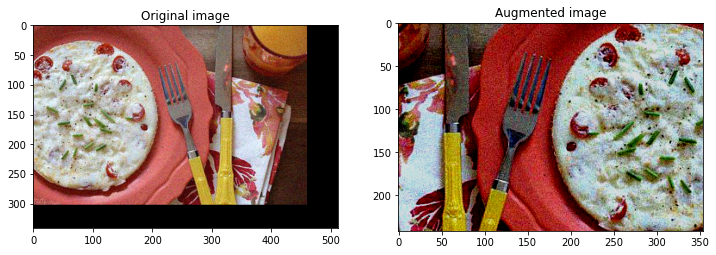

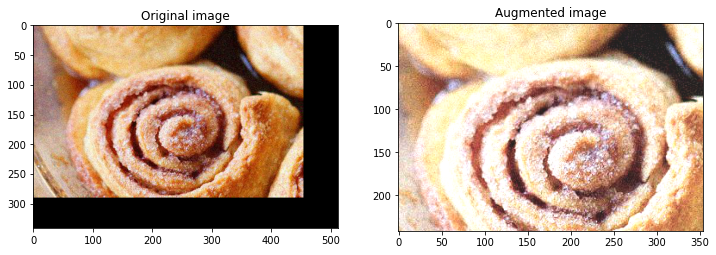

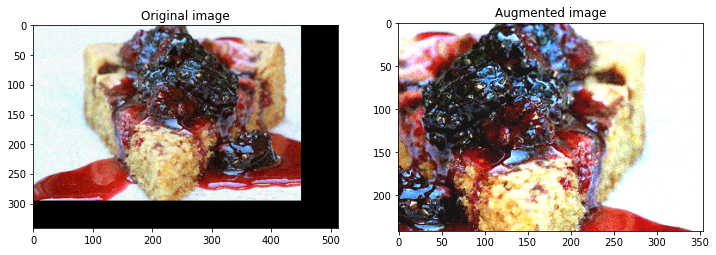

In [ ]:
def augment(image, shape):
  image = tf.image.crop_to_bounding_box(image, 0, 0, shape[0], shape[1])
  image = tf.image.random_crop(image, size=crop_size)
  image = tf.image.resize(image, size=resize_size, method='nearest')
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
  image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
  image = tf.image.random_brightness(image, max_delta=0.3)
  return image

def visualize(i):
  original = images[i]
  shape = image_shapes[i]
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augment(original, shape))

mpl.rcParams['figure.figsize'] = (12, 5)

for i in np.random.randint(0, n_images, 3):
  visualize(i)

In [ ]:
# load training and test data
# note that the set of numbers in X is {0, ..., 4999}
# and the set of numbers in X_test is {5000, ... , 9999}
X_test = pd.read_csv('test_triplets.txt', names="A B C".split(), delim_whitespace=True)
# convert X_test into a dictionary
X_test = {col:X_test[col].values for col in X_test.columns}
X = pd.read_csv('train_triplets.txt', names="A B C".split(), delim_whitespace=True).drop_duplicates(ignore_index=True)

# we need to split X into X_val and X_train s.t. the set of numbers 
# in X_val and X_train are disjoint as it is the case for X and X_test
val_split = 0.2
# we count how often the numbers in a triple occur in X and take the sum
# count_sum should give a measure of "connectedness" for each triple in X
number_count = np.bincount(X.values.flatten())

X_copy = X.copy()
X_copy['count_sum'] = X.apply(lambda triple: number_count[triple].sum(), axis=1)
X_copy.sort_values(by='count_sum', inplace=True)
X_copy

# calc_val_split computes the val_split that results from constructing X_val and X_train s.t.
# X_val consists of all triples in X that only contain numbers that occur in the first i triples 
# of X_copy, i.e. numbers in the set val_numbers. X_train consists of all triples that contain 
# numbers in the set train_numbers. 
# The set of numbers in X_val and X_train are disjoint by construction.
def calc_val_split(i):
  val_numbers = set(X_copy['A B C'.split()].iloc[:i].values.flatten())
  train_numbers = set(range(0, 5000))-val_numbers
  val_index = X.apply(lambda triple: set(triple).issubset(val_numbers), axis=1)
  train_index = X.apply(lambda triple: set(triple).issubset(train_numbers), axis=1)
  X_val = X.loc[val_index]
  X_train = X.loc[train_index]
  v_split = len(X_val)/(len(X_val)+len(X_train))
  return v_split

# search for i_best = argmax_{1<=i<=X.shape[0], calc_val_split(i)<val_split} calc_val_split(i)
# note that calc_val_split(i) is increasing
# search strategy: divide and conquer
a = 1
b = X.shape[0]
searching = True
while searching:
  # the current search window is [a, b]
  mid_point = a + int(round((b-a)/2))
  v_split = calc_val_split(mid_point)
  # stop searching if either a or b equals the mid_point
  searching = (a!=mid_point) & (b!=mid_point)
  if v_split < val_split:
    a = mid_point
  else:
    b = mid_point

i_best = a
val_numbers = set(X_copy['A B C'.split()].iloc[:i_best].values.flatten())
train_numbers = set(range(0, 5000))-val_numbers
val_index = X.apply(lambda triple: set(triple).issubset(val_numbers), axis=1)
train_index = X.apply(lambda triple: set(triple).issubset(train_numbers), axis=1)
X_val = X.loc[val_index]
X_train = X.loc[train_index]
del X, X_copy

def transform(X_original):
  X = X_original.copy()
  X['label'] = 1

  # copy X, switch columns B & C and classify those samples as 0
  X_switched = X["A C B".split()]
  X_switched.columns = "A B C".split()
  X_switched['label'] = 0

  # combine X & X_switched in order to get a balanced dataset 
  # and randomly shuffle the whole dataframe
  X = pd.concat([X, X_switched], ignore_index=True).sample(frac=1)

  # split into features and labels
  y = X["label"].values
  X = X["A B C".split()]

  # convert X into a dictionary
  X = {col:X[col].values for col in X.columns}

  return X, y

X_train, y_train = transform(X_train)
X_val, y_val = transform(X_val)

In [ ]:
############  COMMENTED FOR (FAST) REPRODUCABILITY  ############
############  DEFINITIONS FOR WRITING TFRECORDS      ############

# # some parts copied from: TUTORIAL - TFRecord and tf.Example
# # https://www.tensorflow.org/tutorials/load_data/tfrecord

# # The following functions can be used to convert a value to a type compatible
# # with tf.Example.

# def _bytes_feature(value):
#   """Returns a bytes_list from a string / byte."""
#   if isinstance(value, type(tf.constant(0))):
#     value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
#   return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def _float_feature(value):
#   """Returns a float_list from a float / double."""
#   return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

# def _int64_feature(value):
#   """Returns an int64_list from a bool / enum / int / uint."""
#   return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# def serialize_example(A, B, C, label):
#   """
#   Creates a tf.Example message ready to be written to a file.
#   """
#   # Create a dictionary mapping the feature name to the tf.Example-compatible
#   # data type.
#   feature = {
#       'image_A': _bytes_feature(tf.io.serialize_tensor(images[A])),
#       'image_A_shape': _bytes_feature(tf.io.serialize_tensor(image_shapes[A])),
#       'image_B': _bytes_feature(tf.io.serialize_tensor(images[B])),
#       'image_B_shape': _bytes_feature(tf.io.serialize_tensor(image_shapes[B])),
#       'image_C': _bytes_feature(tf.io.serialize_tensor(images[C])),
#       'image_C_shape': _bytes_feature(tf.io.serialize_tensor(image_shapes[C])),
#       'label': _int64_feature(label),
#   }

#   # Create a Features message using tf.train.Example.
#   example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  
#   return example_proto.SerializeToString()

# def tf_serialize_example(image_triple, label):
#   tf_string = tf.py_function(
#     serialize_example,
#     (image_triple['A'], image_triple['B'], image_triple['C'], label),  # pass these args to the above function.
#     tf.string)                                                         # the return type is `tf.string`.
#   return tf.reshape(tf_string, ()) # The result is a scalar

In [ ]:
############  COMMENTED FOR (FAST) REPRODUCABILITY   ############
############  GRANT ACCESS TO GOOGLE CLOUD PLATFORM  ############

# # https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/keras_mnist_tpu.ipynb
# # Authenticates the Colab machine and also the TPU using your
# # credentials so that they can access your private GCS buckets.

# from google.colab import auth
# auth.authenticate_user()

In [ ]:
############  COMMENTED FOR (FAST) REPRODUCABILITY   ############
############  CREATE GCS BUCKET                      ############

# # define the project ID where you want to create your GCS buckets
# project_id = 'sturdy-sentry-278313'

# # set project
# !gcloud config set project {project_id}

# # generate globally-unique bucket name
# import uuid
# bucket_name = 'colab-bucket-' + str(uuid.uuid1())

# # create new bucket
# !gsutil mb gs://{bucket_name}

# # grant all users permission to read objects stored in this bucket
# !gsutil iam ch allUsers:objectViewer gs://{bucket_name}

In [ ]:
# y_test is just a placeholder, so that we can use the same functions 
# for the test_dataset as for train and val when writing and reading TFRecords
y_test = np.zeros(X_test['A'].shape[0])
datasets = {'train':(X_train, y_train), 'val':(X_val, y_val), 'test':(X_test, y_test)}
# file_size rows take up ~100MB in a TFRecord file
file_size = 67

In [ ]:
############  COMMENTED FOR (FAST) REPRODUCABILITY      ############
############  WRITE TFRECORDS AND UPLOAD TO GCS BUCKET  ############

# start_time = time.time()
# # write TFRecord files to disk
# for name, dataset in datasets.items():
#   X = dataset[0]
#   y = dataset[1]
#   n_samples = len(y)
#   index = np.linspace(start=0, stop=n_samples, num=n_samples//file_size, dtype=np.int64)
#   for i in range(len(index)-1):
#     dataset = tf.data.Dataset.from_tensor_slices(({col:X[col][index[i]:index[i+1]] for col in X.keys()}, y[index[i]:index[i+1]]))
#     serialized_dataset = dataset.map(tf_serialize_example)
#     filename = '{}_{}{}.tfrecord'.format(name, (5-len(str(i)))*'0', i)
#     writer = tf.data.experimental.TFRecordWriter(filename)
#     writer.write(serialized_dataset)
#     if i%500==0:
#       # copy TFRecord files to GCS bucket and delete them from disk
#       !gsutil -m cp -R /content/*.tfrecord gs://{bucket_name}/
#       !rm *.tfrecord
#   # copy TFRecord files to GCS bucket and delete them from disk
#   !gsutil -m cp -R /content/*.tfrecord gs://{bucket_name}/
#   !rm *.tfrecord


# run_time = time.time()-start_time
# print('# runtime: {a:.0f} min {b:.2f} s'.format(a=run_time//60, b=run_time%60))

In [ ]:
# connect to TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.113.39.234:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.113.39.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.113.39.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# define functions that are needed to parse tfrecords from GCS buckets
# Create a description of the features.
feature_description = {
    'image_A': tf.io.FixedLenFeature([], tf.string),
    'image_A_shape': tf.io.FixedLenFeature([], tf.string),
    'image_B': tf.io.FixedLenFeature([], tf.string),
    'image_B_shape': tf.io.FixedLenFeature([], tf.string),
    'image_C': tf.io.FixedLenFeature([], tf.string),
    'image_C_shape': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def augment(image, name=None):
  if name == 'train':
    image = tf.image.random_crop(image, size=crop_size)

  image = tf.image.resize(image, size=resize_size, method='nearest')

  if name == 'train':
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_brightness(image, max_delta=0.1)
  return image

def _parse_function(example_proto, name=None):
  # Parse the input `tf.Example` proto using the dictionary above.
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # create image_triple
  image_triple = {}
  for col in "A B C".split():
    # parse from byte-string back to tensor
    image_triple[col] = tf.ensure_shape(tf.io.parse_tensor(parsed_example['image_'+col], out_type=tf.uint8), padded_shape)
    # crop back to original shape before zero padding
    original_shape = tf.io.parse_tensor(parsed_example['image_'+col+'_shape'], out_type=tf.int32)
    image_triple[col] = tf.image.crop_to_bounding_box(image_triple[col], 0, 0, original_shape[0], original_shape[1])
    # train images are resized and augmented, val and test images are only resized
    image_triple[col] = augment(image_triple[col], name)
    # pre-process images as in pre-trained model
    image_triple[col] = preprocess_input(tf.cast(image_triple[col], tf.float32))

  # get label
  label = parsed_example['label']

  return image_triple, label

In [ ]:
def get_filenames(name):
  filenames = tf.io.gfile.glob('gs://{}/{}_*.tfrecord'.format(bucket_name, name))
  filenames.sort()
  return filenames

filenames = {name:get_filenames(name) for name in datasets.keys()}
print(filenames['test'])
AUTO = tf.data.experimental.AUTOTUNE
batch_size = 64 * tpu_strategy.num_replicas_in_sync
steps_per_epoch = X_train['A'].shape[0] // batch_size
validation_steps = X_val['A'].shape[0] // batch_size
buffer_size = {name:len(dataset[1]) for name, dataset in datasets.items()}

def load_dataset(name):
  if name != 'test':
    # read and cache dataset
    raw_dataset = tf.data.TFRecordDataset(filenames[name], num_parallel_reads=AUTO).cache()
  else:
    # make sure that input files are read sequentially so that the predictions are made in correct order
    files = tf.data.Dataset.from_tensor_slices(filenames[name])
    raw_dataset = files.interleave(lambda file_name: tf.data.TFRecordDataset(file_name), 
                                   block_length=2*file_size, num_parallel_calls=AUTO, deterministic=True).cache()
  
  if name != 'test':
    # shuffle and repeat dataset
    raw_dataset = raw_dataset.shuffle(buffer_size[name]).repeat()
  
  # parse dataset
  parsed_dataset = raw_dataset.map(lambda example_proto: _parse_function(example_proto, name), num_parallel_calls=AUTO)
  
  if name != 'test':
    # batch dataset
    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=True)
  else:
    # do not drop remainder for test_dataset
    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
  
  if name != 'test':
    # prefetch dataset
    parsed_dataset = parsed_dataset.prefetch(AUTO)
  
  return parsed_dataset

['gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00000.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00001.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00002.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00003.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00004.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00005.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00006.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00007.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00008.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00009.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00010.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00011.tfrecord', 'gs://colab-bucket-b269c288-3e3b-11eb-b250-0242ac1c0002/test_00

In [ ]:
train_dataset = load_dataset('train')
val_dataset = load_dataset('val')
# remove placeholder label for test_dataset
test_dataset = load_dataset('test').map(lambda image_triple, label: image_triple, num_parallel_calls=AUTO).prefetch(AUTO)

In [ ]:
def create_model():
  # A) define model
  # first input model
  visible1 = Input(shape=image_shape, name="A")
  pre_trained_model_1 = VGG16(include_top=False, input_tensor=visible1, pooling='avg')
  pre_trained_model_1._name = pre_trained_model_1.name + 'A'
  # mark loaded layers in pre_trained_model_1 as not trainable
  for layer in pre_trained_model_1.layers[1:]:
    layer._name = layer.name + '_A'
    layer.trainable = False
  flat1 = Flatten()(pre_trained_model_1.output)

  # second input model
  visible2 = Input(shape=image_shape, name="B")
  pre_trained_model_2 = VGG16(include_top=False, input_tensor=visible2, pooling='avg')
  pre_trained_model_2._name = pre_trained_model_2.name + 'B'
  # mark loaded layers in pre_trained_model_2 as not trainable
  for layer in pre_trained_model_2.layers[1:]:
    layer._name = layer.name + '_B'
    layer.trainable = False
  flat2 = Flatten()(pre_trained_model_2.output)

  # third input model
  visible3 = Input(shape=image_shape, name="C")
  pre_trained_model_3 = VGG16(include_top=False, input_tensor=visible3, pooling='avg')
  pre_trained_model_3._name = pre_trained_model_3.name + 'C'
  # mark loaded layers in pre_trained_model_3 as not trainable
  for layer in pre_trained_model_3.layers[1:]:
    layer._name = layer.name + '_C'
    layer.trainable = False
  flat3 = Flatten()(pre_trained_model_3.output)

  # merge input models
  merge = Concatenate()([flat1, flat2, flat3])
  drop = Dropout(0.2)(merge)

  # interpretation model
  hidden1 = Dense(1024, activation='relu', kernel_constraint=MaxNorm(3))(drop)
  drop1 = Dropout(0.2)(hidden1)
  hidden2 = Dense(512, activation='relu', kernel_constraint=MaxNorm(3))(drop1)
  drop2 = Dropout(0.2)(hidden2)
  output = Dense(1, activation='sigmoid')(drop2)
  model = Model(inputs=[visible1, visible2, visible3], outputs=output)
  
  # B) compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


# define and compile model
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()

# summarize layers
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
A (InputLayer)                  [(None, 242, 354, 3) 0                                            
__________________________________________________________________________________________________
B (InputLayer)                  [(None, 242, 354, 3) 0                                            
__________________________________________________________________________________________________
C (InputLayer)                  [(None, 242, 354, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_A (Conv2D)         (None, 242, 354, 64) 1792        A[0][0]                          
______________________

In [ ]:
# define simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# define ModelCheckpoint in order to save the best model weights
filename = 'model_weights.h5'
mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True, save_weights_only=True)
callbacks = [es, mc]

print('# fit model')
start_time = time.time()
model_history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, 
                          validation_data=val_dataset, validation_steps=validation_steps,
                          epochs=5000, callbacks=callbacks)
run_time = time.time()-start_time
print('# fit model: runtime: {a:.0f} h {b:.0f} min {c:.2f} s'.format(a=run_time//3600, b=(run_time-(run_time//3600)*3600)//60, c=run_time%60))

# fit model
Epoch 1/5000
 2/64 [..............................] - ETA: 1:02 - loss: 20.0412 - accuracy: 0.5039WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0033s vs `on_train_batch_end` time: 2.0061s). Check your callbacks.


64/64 [==============================] - ETA: 0s - loss: 1.8509 - accuracy: 0.5234WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0025s vs `on_test_batch_end` time: 1.1995s). Check your callbacks.



Epoch 00001: val_accuracy improved from -inf to 0.58069, saving model to model_weights.h5
64/64 [==============================] - 135s 2s/step - loss: 1.8509 - accuracy: 0.5234 - val_loss: 0.6760 - val_accuracy: 0.5807
Epoch 2/5000
64/64 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.5842
Epoch 00002: val_accuracy improved from 0.58069 to 0.65295, saving model to model_weights.h5
64/64 [==============================] - 104s 2s/step - loss: 0.6672 - accuracy: 0.5842 - val_loss: 0.6198 - val_accuracy: 0.6530
Epoch 3/5000
64/64 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.6469
Epoch 00003: val_accuracy improved from 0.65295 to 0.67041, saving model to model_weights.h5
64/64 [==============================] - 105s 2s/step - loss: 0.6237 - accuracy: 0.6469 - val_loss: 0.5923 - val_accuracy: 0.6704
Epoch 4/5000
64/64 [==============================] - ETA: 0s - loss: 0.5979 - accuracy: 0.6711
Epoch 00004: val_accuracy improved from 0.670

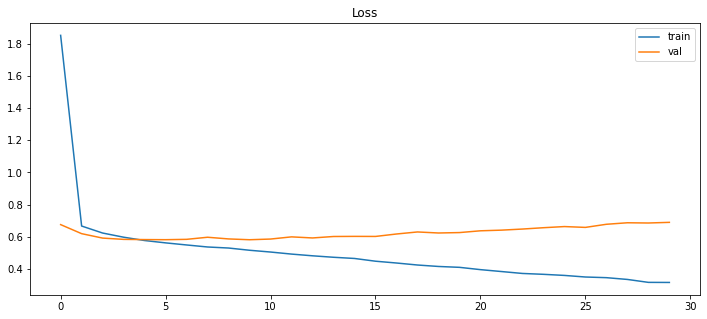

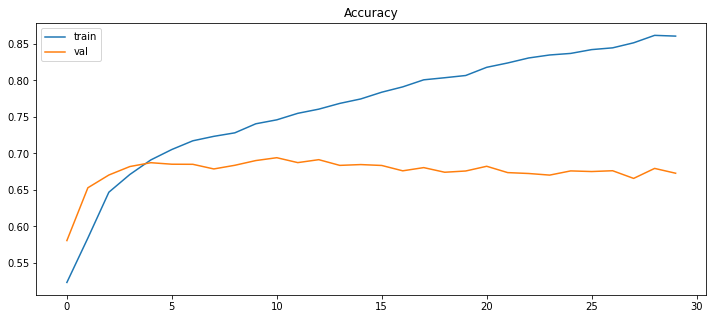

In [ ]:
# plot training history
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()
plt.show()
plt.plot(model_history.history['accuracy'], label='train')
plt.plot(model_history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
start_time = time.time()
model.load_weights(filename)
run_time = time.time()-start_time
print('# load best model weights: runtime: {a:.0f} min {b:.2f} s'.format(a=run_time//60, b=run_time%60))

print('# make predictions')
start_time = time.time()
predictions = model.predict(test_dataset, verbose=1)
run_time = time.time()-start_time
print('# make predictions: runtime: {a:.0f} min {b:.2f} s'.format(a=run_time//60, b=run_time%60))

# save predictions
############  NEXT TWO LINES COMMENTED FOR REPRODUCABILITY  ############
# from os import chdir
# chdir('/content/drive/My Drive/IML_2020/Project/Task_4/')
np.savetxt('Submission_{}.txt'.format(main_filename), predictions.round(), fmt='%d')

# load best model weights: runtime: 0 min 3.77 s
# make predictions
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


117/117 [==============================] - 166s 1s/step
# make predictions: runtime: 3 min 32.11 s


In [ ]:
############  COMMENTED FOR (FAST) REPRODUCABILITY   ############

# print('# delete bucket and its content')
# start_time = time.time()
# !gsutil -m rm -r gs://{bucket_name}
# run_time = time.time()-start_time
# print('# delete bucket and its content: runtime: {a:.0f} min {b:.2f} s'.format(a=run_time//60, b=run_time%60))

In [ ]:
############  COMMENTED FOR (FAST) REPRODUCABILITY   ############

# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')